In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [33]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [36]:
# We can view all of the classes that automap found
Base.classes.keys()
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [ ]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [40]:
# View table columns
for table in inspector.get_table_names():
    print(table)
    for column in inspector.get_columns(table):
        print(column['name'], column['type'])
    print()

measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



# Exploratory Climate Analysis

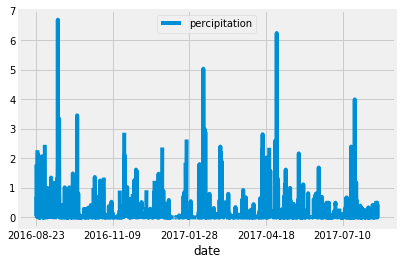

In [431]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(func.max(Measurement.date)).first()[0]
end_date = dt.datetime.strptime(max_date, "%Y-%m-%d")
start_date = end_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp) \
    .filter(Measurement.date >= start_date.strftime("%Y-%m-%d")) \
    .filter(Measurement.date <= end_date.strftime("%Y-%m-%d")).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data_df = pd.DataFrame(data)
data_df.set_index("date", inplace=True)
data_df.rename(columns={"prcp": "percipitation"}, inplace=True)

# Sort the dataframe by date
data_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
data_df.plot()
plt.legend(loc="upper center")
plt.show()

In [145]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_df.describe()

,percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [174]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [201]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [210]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#station_id = 
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
    .filter(Measurement.station == stations[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

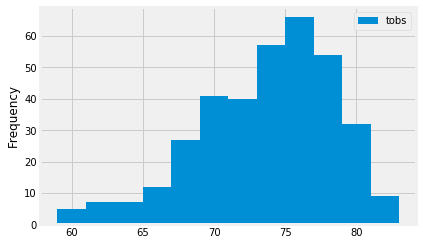

In [267]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_date = session.query(func.max(Measurement.date)).filter(Measurement.station == stations[0][0]).first()[0]
end_date = dt.datetime.strptime(max_date, "%Y-%m-%d")
start_date = end_date - dt.timedelta(days=365)

observations = session.query(Measurement.tobs) \
    .filter(Measurement.station == stations[0][0]) \
    .filter(Measurement.date >= start_date.strftime("%Y-%m-%d")) \
    .filter(Measurement.date <= end_date.strftime("%Y-%m-%d")).all()
pd.DataFrame(observations).plot(kind="hist", bins=12)
plt.show()

In [264]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [567]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start="2017-01-01"
trip_end="2017-01-07"

trip = calc_temps(trip_start, trip_end)
print(trip)

[(62.0, 68.36585365853658, 74.0)]


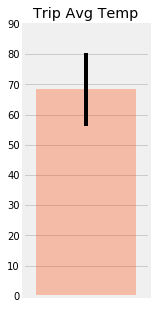

In [568]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(2,5))
plt.bar(0, trip[0][1], color="orangered", alpha=0.30)
plt.xticks([])
plt.ylim(ymax=90)
plt.xlim(xmin=-0.5, xmax=0.5)
plt.title("Trip Avg Temp")
plt.errorbar(x=0, y=trip[0][1], yerr=trip[0][2]-trip[0][0], color="black")
plt.show()

In [569]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_rain = []
for row in session.query(Station.station, Station.name, Station.latitude, Station.longitude, \
    Station.elevation, func.sum(Measurement.prcp)).filter(Station.station == Measurement.station)\
    .filter(Measurement.date >= trip_start).filter(Measurement.date <= trip_end) \
    .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all():
    trip_rain.append(row)

print(trip_rain)

[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.61), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.6), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.35), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.2), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]


## Optional Challenge Assignment

In [502]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [549]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
trip_start="2018-01-01"
trip_end="2018-01-07"

# Use the start and end date to create a range of dates
start = dt.datetime.strptime(trip_start, "%Y-%m-%d")
end = dt.datetime.strptime(trip_end, "%Y-%m-%d")
trip_range = [start + dt.timedelta(days=x) for x in range(0, (end-start).days+1)]

# Stip off the year and save a list of %m-%d strings
trip_range_string = [dt.datetime.strftime(x, "%m-%d") for x in trip_range]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(x)[0] for x in trip_range_string]
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [550]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
data = pd.DataFrame(data=normals, columns=["tmin", "tavg", "tmax"])
data["date"] = [dt.datetime.strftime(x, "%Y-%m-%d") for x in trip_range]
data.set_index("date", inplace=True)
data

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


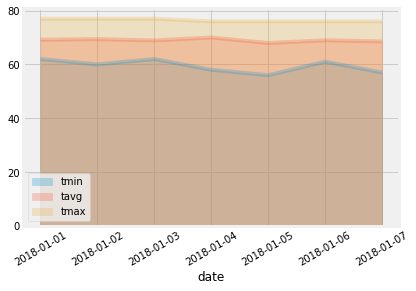

In [561]:
# Plot the daily normals as an area plot with `stacked=False`
data.plot(kind="area", stacked=False, alpha=0.25)
plt.xticks(rotation=30)
plt.yticks(np.arange(0, 100, 20))
plt.show()